# Part 1 - Common Analysis | Feedback Implementation

This notebook focuses on the implementation of feedback provided in the Part 1 evaluation

## Setup

We first set the working dependencies and constants that are required to process. 

The setup contains the following steps
1. Import all relevant packages
2. Define all the relevant constants that will be used throughout the script.

In [1]:
# Import the sys module, which provides access to variables used or maintained by the Python interpreter
import sys

# Import the pandas library and alias it as pd
import pandas as pd

# Import the numpy library and alias it as np
import numpy as np

# Import the json module, which provides methods for working with JSON data
import json

# Import the time library 
import time

# Import the warnings library 
import warnings

# Ignore warnings for this demonstration
warnings.filterwarnings("ignore")

# Import the matplot library and alias it as plt
import matplotlib.pyplot as plt


## Feedback 1 - Calculate AQI for the fire Season

Issue - An annual fire season will run from May 1st through October 31st. Currently the AQI for a year has errenously been calculated as the average AQI over all months. This has to be altered to include the AQI only from May to October.

- What to change?
    1. The AQI_DataPull_1963_2023_monthly.csv is considered as it contains the information of AQI for all months of 1963 to 2023
    2. Filter the AQI for months of May to October for each year
    3. Aggregate it a yearly level by taking average
    4. Save the data as an intermediate file 
    5. Use the updated file to join and create yearly wildfire attributes
    6. Redo the visual analysis question - "Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city."
    
- Impact of the change
    1. There will be an addtional intermediate file containing AQI limited for the fire season details at yearly level
    2. The wildfire_smoke_estimates.csv will be updated with new AQI estimates
    3. Vizualization 3 will undergo alteration

### Filtering AQI for Fire Season

In [2]:
# Load the AQI data

# Path of the AQI data
aqi_data_path = r"C:\Users\shwet\Documents\local-wildfire-project\Data512-WildFire-Project\02_data\02_intermediate_data\AQI_DataPull_1963_2023_monthly.csv"

# Read AQI data
aqi_data = pd.read_csv(aqi_data_path, index_col = 0)

# Sample
aqi_data.head()

,date,aqi,pollutant_id
0,1998-01-31,5.000000,NaN
1,1998-02-28,6.666667,NaN
2,1998-03-31,6.800000,NaN
3,1998-04-30,7.600000,NaN
4,1998-05-31,12.600000,NaN


In [3]:
# Filter AQI for months May to October
aqi_data['date'] = pd.to_datetime(aqi_data['date'])
aqi_filtered = aqi_data[(aqi_data['date'].dt.month >= 5) & (aqi_data['date'].dt.month <= 10)]

# Check
aqi_filtered['date'].dt.month.unique()

array([ 5,  6,  7,  8,  9, 10])

In [4]:
# Aggregate AQI data yearly
aqi_filtered['year'] = aqi_filtered['date'].dt.year
aqi_yearly = aqi_filtered.groupby('year')['aqi'].mean().reset_index()

# sample 
aqi_yearly.head()

,year,aqi
0,1998,10.400000
1,1999,15.803472
2,2000,15.758851
3,2001,25.503388
4,2002,17.651063


### Joining it with Fire Attributes and Smoke estimates

In [5]:
# Load the smoke estimates data and AQI data
smoke_est_df = pd.read_csv(r"C:\Users\shwet\Documents\local-wildfire-project\Data512-WildFire-Project\02_data\02_intermediate_data\yearly_smoke_estimates.csv", index_col=0)

In [6]:
# Ensure columns are in integer format for merging
aqi_yearly['year'] = aqi_yearly['year'].astype(int)
smoke_est_df['Fire_Year'] = smoke_est_df['Fire_Year'].astype(int)

In [7]:
# Merge smoke estimates with AQI data on the 'year' column
smoke_data = pd.merge(smoke_est_df, aqi_yearly, left_on='Fire_Year', right_on='year', how='outer')

In [8]:
# Update column names and rearrange the DataFrame
smoke_data['year'] = smoke_data['year'].fillna(smoke_data['Fire_Year'])  # Fill NaN in 'year' column with 'Fire_Year'
smoke_data = smoke_data[['year', 'GIS_Acres', 'Shape_Area', 'shortest_dist', 'fire_intensity',
                         'scaled_overlap_component', 'smoke_estimate', 'aqi']]  # Select desired columns
smoke_data['aqi'] = smoke_data['aqi'].fillna(0)  # Fill NaN values in 'aqi' with 0

In [9]:
# Save the final DataFrame to a CSV file
smoke_data.to_csv(r"C:\Users\shwet\Documents\local-wildfire-project\Data512-WildFire-Project\02_data\03_final_data\final_yearly_wildfire_data_w_smokeestimate_aqi.csv")

##  Time series Graph

Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

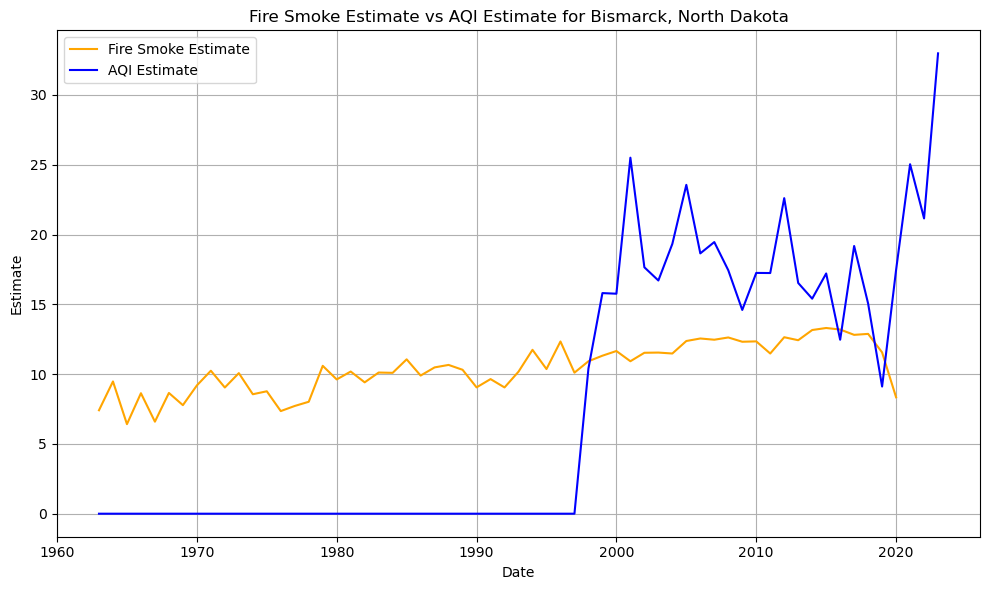

In [10]:
# Plotting the time series graph
plt.figure(figsize=(10, 6))

# Plot fire smoke estimate
plt.plot(smoke_data['year'], smoke_data['smoke_estimate'], label='Fire Smoke Estimate', color='orange')

# Plot AQI estimate
plt.plot(smoke_data['year'], smoke_data['aqi'], label='AQI Estimate', color='blue')

plt.xlabel('Date')
plt.ylabel('Estimate')
plt.title('Fire Smoke Estimate vs AQI Estimate for Bismarck, North Dakota')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Feedback 2 - Fix Wildfire Histogram

Issue - The question is to `Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.`
- Currently the data used to plot this chart is a yearly fire estimate with AQI. However, the data required for the histogram is supposed be at a wildfire level. The data is unfortunately at a yearly level which is misrepresented as the number of fires in the histogram. This yeilds a low count of fire in the histogram. Current order of fire is 50-60; Actual order of fire is in the 90000+.

- What to change?
    1. Plot the histogram for individual fires
    2. Switch out the 
        - final data 
        `("Data512-WildFire-Project\02_data\03_final_data\final_yearly_wildfire_data_w_smokeestimate_aqi.csv")`
        - with the intermediate data 
        `("Data512-WildFire-Project\02_data\02_intermediate_data\wildfire_smoke_estimates.csv")`
    
- Impact of the change
    1. Vizualization 1 the histogram will undergo alteration
    2. Alter the reflection tied to the histogram

In [13]:
wildfire_data = pd.read_csv(r"C:\Users\shwet\Documents\local-wildfire-project\Data512-WildFire-Project\02_data\02_intermediate_data\wildfire_smoke_estimates.csv", index_col = 0)

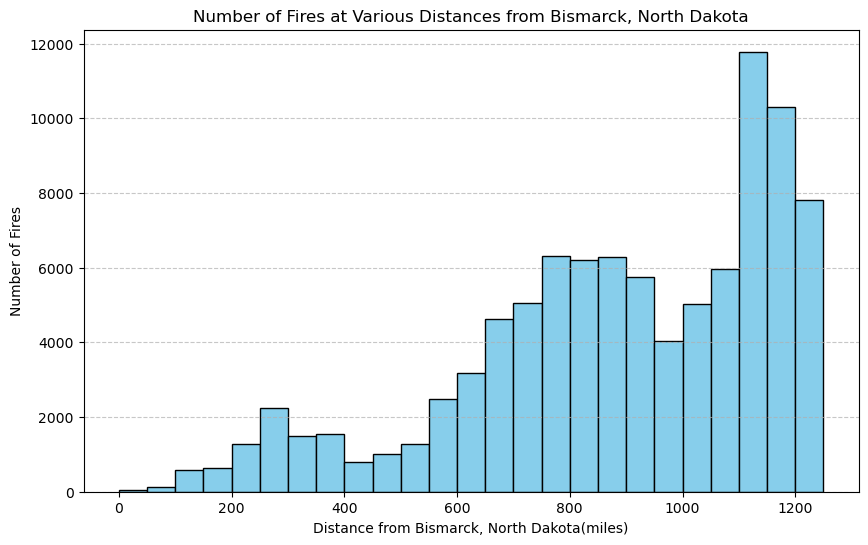

In [14]:
# Define the maximum specified distance
max_distance = 1250  

# Create a histogram with bins every 50 miles up to the max specified distance
plt.figure(figsize=(10, 6))
plt.hist(wildfire_data['shortest_dist'], bins=range(0, max_distance + 50, 50), color='skyblue', edgecolor='black')
plt.xlabel('Distance from Bismarck, North Dakota(miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires at Various Distances from Bismarck, North Dakota')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Graph Description

The graph above represents the histogram of the fires and their distribution over the distance from Bismarck, North Dakota. The histogram illustrates the spatial distribution of fires concerning their occurrence frequency at 50-mile intervals from the assigned city.

What Does the Figure Show?
1. Provides a visual representation of the count of fires occurring within predetermined distances up to the specified maximum distance from the city.
2. Provides a trend that might influence further analysis on the cause of fires within a particular spatial location.

How Does the Viewer “Read” the Figure?
1. Each bar on the horizontal axis signifies a 50-mile distance range from the assigned city. The heightof the bars represents the number of fires occurring within each interval.
2. Interpret the varying heights of the bars to ascertain the density or concentration of fires across different distance bands from the city.

What Are the Axes, and What Do They Represent?

Horizontal Axis: Represents distance intervals from the assigned city, grouped at 50-mile increments,
showcasing the spatial spread of fires.
Vertical Axis: Indicates the count or frequency of fires occurring within each respective 50-mile interval, reflecting the number of fire occurrences.

What Is the Underlying Data and How Was It Processed?
Data Source: The processed data obtained from the GeoJson containing the wildfire attributes across the US led to estimates of the smoke impact on the city of Bismarck.

Interpretation of the Graph:
1. The histogram helps us to ascertain the pattern of the wildfires are taking. Provides the information that can be leveraged to assess risk or allocate resources for fire damage management at certain regions
2. Observers analyze the distribution pattern to discern areas or distance bands around the city with higher or lower fire frequency.